In [5]:
#NEW model version
import mesa
import numpy as np
from scipy.stats import norm
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Deque
from scipy.optimize import bisect, minimize
from scipy.optimize import differential_evolution


def custom_curve(x, a, b):
    if x < 0:
        return 0.0
    return 100 * (1 - np.exp(-a * x**b))


def generate_parameters(t, a_min=2, a_max=4, b_min=0.7, b_max=0.9):
    a = a_max - (a_max - a_min) * t
    b = b_min + (b_max - b_min) * t
    return a, b


def func_for_bisect(x, a, b, score):
    return custom_curve(x, a, b) - score


def get_project_awards(m):
    return m.project_awards


def get_all_projects(model):
    return model.all_projects

def get_past_bids(agent):
    filtered_bids = []
    for bid in agent.contractor.past_bids:
        filtered_bids.append({
            'bid_id': bid.bid_id,
            'original_amount': bid.original_amount,
            'bid_ratio':bid.bid_ratio,
            'project_appraisal_value': bid.project.appraisal_value,
            'contractor_id': bid.contractor_id,
            'perceived_cost': bid.perceived_cost,
            'sustainability_score': bid.sustainability_score,
            'step': bid.step,
            'won': bid.won,
            'expected_utility': bid.expected_utility,
        })
    return filtered_bids

def get_completed_projects(agent):
    return agent.contractor.completed_projects

def get_contractor_states(m):
    contractor_states = {}
    for agent in m.schedule.agents:
        contractor = agent.contractor
        contractor_states[contractor.id] = {
            'risk_aversion': contractor.risk_aversion,
            't_value': contractor.t_value,
            'experience': contractor.experience,
            'financial_stress_class': contractor.financial_stress_class,
            'net_worth': contractor.net_worth,
        }
    return contractor_states

# Function for optimizing sustainability investment
def sustainability_investment_objective(investment, markup, contractor_agent, estimated_cost, project, opponents):
    return -contractor_agent._objective_function((markup, investment), estimated_cost, project, opponents)

# Function for optimizing markup
def markup_objective(markup, investment, contractor_agent, estimated_cost, project, opponents):
    return -contractor_agent._objective_function((markup, investment), estimated_cost, project, opponents)

# Function for joint local optimization
def joint_optimization_objective(x, contractor_agent, estimated_cost, project, opponents):
    markup, investment = x
    return -contractor_agent._objective_function((markup, investment), estimated_cost, project, opponents)


@dataclass
class ProjectAward:
    step: int
    project_id: int
    winning_bid_id: int
    winning_contractor_id: int
    num_bidders: int

@dataclass
class Owner:
    id: int
    award_method: str
    sustainability_method: Optional[str]
    desired_sustainability_score: float
    sustainability_curve_t: float
    project_generation_rate: float


@dataclass
class Project:
    id: int
    appraisal_value: float
    sustainability_appraisal_value: float
    complexity: float
    mean_duration: float
    desired_sustainability_score: float
    sustainability_curve_t: float
    award_method: str
    sustainability_method: Optional[str]
    owner_id: int
    state: str = 'inbidding'
    participating_contractors: List[int] = field(default_factory=list)
    bids: List['Bid'] = field(default_factory=list)  # **Added this line**

    def get_curve_parameters(self):
        return generate_parameters(self.sustainability_curve_t)

    def investment_for_score(self, score, a, b):
        x = bisect(func_for_bisect, 0, 1, args=(a, b, score))
        return x

    def calculate_sustainability_appraisal_value(self):
        if self.desired_sustainability_score == 0:
            self.sustainability_appraisal_value = 0
            return

        a, b = self.get_curve_parameters()
        investment_percentage = self.investment_for_score(self.desired_sustainability_score, a, b)
        investment_percentage = max(0.0, min(investment_percentage, 1.0))

        self.sustainability_appraisal_value = self.appraisal_value * investment_percentage

        return self.sustainability_appraisal_value, investment_percentage

    def get_sustainability_discount_rate(self):
        a, b = self.get_curve_parameters()
        desired_investment = self.investment_for_score(self.desired_sustainability_score, a, b)

        x = desired_investment
        derivative = 100 * a * b * x**(b - 1) * np.exp(-a * x**b)
        gradient = derivative

        epsilon = 1e-4
        discount_factor = 1 / (gradient + epsilon)
        discount_factor = min(discount_factor, 1.0)
        discount_factor = max(0.0, discount_factor)

        return discount_factor

    def get_perceived_cost(self, contractor):
        beta_0 = 0.0129
        beta_1 = 0.989
        beta_4 = -0.0218
        city_millions = self.appraisal_value / 1e6
        fs_i = contractor.financial_stress_class
        mu_i = beta_0 + beta_1 * np.log(city_millions) + beta_4 * fs_i
        sigma_i = (1 - contractor.estimation_accuracy)
        log_perceived_cost = np.random.normal(mu_i, sigma_i)
        perceived_cost_millions = np.exp(log_perceived_cost)
        perceived_cost = perceived_cost_millions * 1e6
        return perceived_cost

    def get_actual_duration(self, contractor):
        skill = contractor.project_management_skill
        if skill <= 0.5:
            beta = 2
            alpha = 8 - 12 * skill
        else:
            alpha = 2
            beta = 2 + 12 * (skill - 0.5)
        beta_value = np.random.beta(alpha, beta)
        min_duration = max(self.mean_duration * 0.5, 1)
        max_duration = self.mean_duration * 1.5
        actual_duration = min_duration + beta_value * (max_duration - min_duration)
        return actual_duration

    def actual_cost_determination(self, contractor, perceived_cost):
        management_skill = contractor.project_management_skill
        std_dev = (1 - management_skill) * self.complexity
        actual_cost = np.random.normal(perceived_cost, std_dev)
        actual_cost = max(actual_cost, 0.8 * perceived_cost)
        return actual_cost


@dataclass
class Bid:
    bid_id: int
    original_amount: float
    evaluated_amount: Optional[float]
    bid_ratio: float
    evaluated_bid_ratio: Optional[float]
    contractor_id: int
    perceived_cost: float
    project_id: int
    sustainability_score: float
    step: int
    project: Project  # Moved before fields with default values
    investment_percentage: float = 0.0
    won: bool = False
    expected_utility: Optional[float] = None  

@dataclass
class Contractor:
    id: int
    experience: float
    financial_stress_class: int
    estimation_accuracy: float
    work_in_progress_limit: int
    general_and_administrative_costs: float
    project_management_skill: float
    net_worth: float
    current_work_volume: int
    active_projects: List[dict]
    personal_risk_aversion: float
    relative_wealth_factor: float
    t_value: float = 1 # Now set directly
    risk_aversion: float = 0.0
    mean_bid_ratio: float = 1.1
    std_bid_ratio: float = 0.05
    past_bids: List[Bid] = field(default_factory=list)
    completed_projects: List[dict] = field(default_factory=list)
    utility_threshold: float = 0.0

    def __post_init__(self):
        self.risk_aversion = self.calculate_risk_aversion()
        
    def calculate_risk_aversion(self, project_perceived_cost: float = 0) -> float:
        gamma_0, gamma_1 = 0.145, 0.0171
        exp_risk_tolerance = min(gamma_0 + gamma_1 * self.experience, 1.0)
        total_risk_tolerance = max(exp_risk_tolerance, 0.0)
        with_wealth = min(1-((1+self.personal_risk_aversion)*total_risk_tolerance * (1 + self.relative_wealth_factor * (project_perceived_cost / self.net_worth))), 1.0)
        final_with_wealth = max(with_wealth, 0.0)
        without_wealth = min((1-(1+self.personal_risk_aversion)*total_risk_tolerance), 1.0)
        final_without_wealth = max(without_wealth, 0.0)
        if self.relative_wealth_factor > 0:
            return final_with_wealth
        else:
            return final_without_wealth

    def get_contractor_t(self):
        fs_normalized = (self.financial_stress_class - 1) / 4  # Normalize to 0-1
        sustainability_experience = min(self.sustainability_experience / 10, 1)  # Between 0 and 1
        t = 0.5 * fs_normalized + 0.5 * (1 - sustainability_experience)
        t = max(0.0, min(t, 1.0))
        return t

    def update_bid_statistics(self):
        # Collect bid ratios, prioritizing evaluated bid ratios if available
        bid_ratios = []
        for bid in self.past_bids:
            # Cap evaluated bid ratio to a maximum of 1.5 if it’s extreme due to sustainability filter
            ratio = bid.evaluated_bid_ratio if bid.evaluated_bid_ratio and bid.evaluated_bid_ratio <= 1.5 else bid.bid_ratio
            bid_ratios.append(ratio)

        if bid_ratios:
            alpha = 0.05  # Adjust as needed
            n = len(bid_ratios)

            # Calculate weights
            weights = np.array([(1 - alpha) ** i for i in reversed(range(n))])
            weights /= weights.sum()

            bid_ratios_array = np.array(bid_ratios)
            self.mean_bid_ratio = np.dot(weights, bid_ratios_array)

            deviations = bid_ratios_array - self.mean_bid_ratio
            variance = np.dot(weights, deviations ** 2)
            self.std_bid_ratio = max(np.sqrt(variance),0.01)
        else:
            # Fallback values if no past bids or bid ratios are available
            self.mean_bid_ratio = 1.1
            self.std_bid_ratio = 0.05

    def update_utility_threshold(self):
        # Use the expected utilities from past won bids
        won_bids = [bid for bid in self.past_bids if bid.won]
        if len(won_bids) >= 5:
            # Use the last 5 utilities
            recent_bids = won_bids[-5:]
            past_utilities = [bid.expected_utility for bid in recent_bids if hasattr(bid, 'expected_utility')]
            if past_utilities:  # Add a check to avoid min() on empty list
                lowest_utility = min(past_utilities)
                self.utility_threshold = lowest_utility 
            else:
                self.utility_threshold = 0.0
        else:
            # Keep utility threshold at zero until 5 successful projects
            self.utility_threshold = 0.0


class ContractorAgent(mesa.Agent):
    def __init__(self, unique_id: int, model: 'BiddingModel', contractor: Contractor):
        super().__init__(unique_id, model)
        self.contractor = contractor

    def shall_bid(self, project: Project) -> bool:
        return True  # Decide not to bid

    def submit_bid(self, project: Project):
        if self.unique_id not in project.participating_contractors:
            return  # Not bidding on this project

        perceived_cost = project.get_perceived_cost(self.contractor)
        opponents = [self.model.agent_dict[cid] for cid in project.participating_contractors if cid != self.unique_id]

        # Initialization logic for the first three projects
        if project.id < 1:
            markup =1.1
            investment_percentage = self.optimize_sustainability_investment(markup, perceived_cost, project, opponents)
            expected_utility = 1
        else:
            # Use optimization for bid calculation
            result = self.optimal_bid(perceived_cost, project, opponents)
            if result is None:
                project.participating_contractors.remove(self.unique_id)
                return  # Drop out
            else:
                markup, investment_percentage, expected_utility = result

        sustainability_score = self.sustainability_curve(investment_percentage)
        sustainability_cost = perceived_cost * investment_percentage
        total_perceived_cost = perceived_cost + sustainability_cost
        bid_amount = (project.appraisal_value * markup) + sustainability_cost
        bid_ratio = bid_amount /(project.appraisal_value + project.sustainability_appraisal_value)

        bid = Bid(
            bid_id=self.model.next_bid_id,
            original_amount=bid_amount,
            evaluated_amount=None,
            bid_ratio=bid_ratio,
            evaluated_bid_ratio=None,
            contractor_id=self.unique_id,
            perceived_cost=total_perceived_cost,
            project_id=project.id,
            sustainability_score=sustainability_score,
            step=self.model.schedule.steps,
            project=project,
            investment_percentage=investment_percentage,
            won=False,
            expected_utility=expected_utility
        )

        self.model.next_bid_id += 1  # Increment bid ID

        # Add the bid to the project.bids
        project.bids.append(bid)  # Only add to project.bids now, not past_bids yet

    def get_potential_opponents(self):
        potential_opponents = []
        for opponent_id, opponent_agent in self.model.agent_dict.items():
            if opponent_id != self.unique_id:
                if opponent_agent.contractor.current_work_volume < opponent_agent.contractor.work_in_progress_limit:
                    potential_opponents.append(opponent_agent)
        return potential_opponents

    def get_actual_opponents(self, project):
        actual_opponent_ids = [cid for cid in project.participating_contractors if cid != self.unique_id]
        actual_opponents = [self.model.agent_dict[cid] for cid in actual_opponent_ids]
        return actual_opponents

    def sustainability_curve(self, investment_percentage: float) -> float:
        t = self.contractor.t_value
        a, b = generate_parameters(t)
        x = investment_percentage
        assessment_rating = custom_curve(x, a, b)
        return assessment_rating

    def calculate_sustainability_win_prob_filter(self, score: float, project: Project) -> float:
        sustainability_method = project.sustainability_method
        if sustainability_method in [None, 'None']:
            return 1.0  # No effect if there's no sustainability method
        if sustainability_method == 'minimum':
            return self.calculate_sustainability_win_prob_filter_minimum_score(score, project)
        elif sustainability_method == 'discount':
            return self.calculate_sustainability_win_prob_filter_discount(score, project)
        elif sustainability_method == 'scaling_discount':
            return self.calculate_sustainability_win_prob_filter_scaling_discount(score, project)
        else:
            return 1
            
    def calculate_sustainability_win_prob_filter_discount(self, score: float, project: Project) -> float:
        investment_rate = project.sustainability_appraisal_value / project.appraisal_value
        discount_rate = project.get_sustainability_discount_rate()

        # Set a cap on the score for discount calculation
        capped_score = min(score, project.desired_sustainability_score + 20)

        # Disqualify the bid if the score is below the desired level
        if score < project.desired_sustainability_score:
            return 1  # Disqualify the bid
        else:
            # Apply the capped score to calculate the discount
            sustainability_factor = 1 - (capped_score * discount_rate)
            sustainability_factor = max(0, sustainability_factor)  # Ensure it's non-negative

        return sustainability_factor


    def calculate_sustainability_win_prob_filter_minimum_score(self, score: float, project: Project) -> float:
        if score < project.desired_sustainability_score:
            # Apply a penalty that smoothly increases as the score decreases
            return 10 #+np.exp(-10 * (score - project.desired_sustainability_score))
        else:
            return 1

    def calculate_sustainability_win_prob_filter_scaling_discount(self, score: float, project: Project) -> float:
        discount_rate = project.get_sustainability_discount_rate()
        sustainability_factor = 1 - (score * discount_rate)
        sustainability_factor = max(0.0, min(sustainability_factor, 1.0))
        return sustainability_factor

    def calculate_win_prob(self, markup: float, opponents: List['ContractorAgent'], project: Project) -> float:
        award_method = project.award_method
        if award_method == 'lowest':
            return self.calculate_win_prob_lowest(markup, opponents)
        elif award_method == 'second_lowest':
            return self.calculate_win_prob_second_lowest(markup, opponents)
        elif award_method == 'below_average':
            return self.calculate_win_prob_below_average(markup, opponents)
        else:
            return self.calculate_win_prob_lowest(markup, opponents)  # Default to 'lowest'
            
    def apply_probability_weighting(self, win_prob: float, alpha: float = 0.65) -> float:
        if win_prob > 0:
            win_prob_weighted = np.exp(-(-np.log(win_prob)) ** alpha)
        else:
            win_prob_weighted = 0.0

        return max(win_prob_weighted, 1e-10)  # Ensure a minimum value
        
    def calculate_win_prob_lowest(self, markup: float, opponents: List['ContractorAgent']) -> float:
        win_prob = 1.0
        for opponent_agent in opponents:
            opponent_contractor = opponent_agent.contractor
            mean_ratio = opponent_contractor.mean_bid_ratio
            std_ratio = opponent_contractor.std_bid_ratio

            # Debugging print statements
            if std_ratio == 0:
                print(f"Warning: std_ratio is zero for contractor {opponent_contractor.id}")
                std_ratio = 1e-5  # Small non-zero value to prevent division by zero

            survival_prob = 1 - norm.cdf(markup, loc=mean_ratio, scale=std_ratio)
            win_prob *= survival_prob

        return self.apply_probability_weighting(win_prob)

    def calculate_win_prob_second_lowest(self, markup: float, opponents: List['ContractorAgent']) -> float:
        num_opponents = len(opponents)
        if num_opponents < 1:
            return 0
        win_probs = []
        for opponent_agent in opponents:
            opponent_contractor = opponent_agent.contractor
            mean_ratio = opponent_contractor.mean_bid_ratio
            std_ratio = opponent_contractor.std_bid_ratio
            win_prob = 1 - norm.cdf(markup, mean_ratio, std_ratio)
            win_probs.append(win_prob)
        win_probs.sort(reverse=True)
        # Calculate the probability of being the second-lowest bidder
        prob_second_lowest = 0
        for i in range(num_opponents):
            p_i = 1 - win_probs[i]  # Probability that opponent i bids lower than you
            p_others = np.prod([win_probs[j] for j in range(num_opponents) if j != i])
            prob_second_lowest += p_i * p_others

        prob_second_lowest = min(prob_second_lowest, 0.99)
    
        # Apply probability weighting
        return self.apply_probability_weighting(prob_second_lowest)

    def calculate_win_prob_below_average(self, markup: float, opponents: List['ContractorAgent']) -> float:
        num_opponents = len(opponents)
        if num_opponents < 1:
            return 1  # If no opponents, you win by default
        # Approximate the average bid ratio of opponents
        avg_bid_ratios = []
        for opponent_agent in opponents:
            opponent_contractor = opponent_agent.contractor
            avg_bid_ratios.append(opponent_contractor.mean_bid_ratio)
        estimated_avg_bid_ratio = np.mean(avg_bid_ratios)
        # Estimate the standard deviation of the average
        estimated_std = np.std(avg_bid_ratios) / np.sqrt(num_opponents)
        # Calculate the probability that your markup is less than the average opponent bid
        win_prob = norm.cdf(markup, estimated_avg_bid_ratio, estimated_std)
        win_prob = min(win_prob, 0.99)
    
        # Apply probability weighting
        return self.apply_probability_weighting(win_prob)

    def optimal_bid(self, estimated_cost, project, opponents):
        # Step 1: Optimize sustainability investment
        initial_markup = 1.1  # Reasonable starting point
        optimized_investment = self.optimize_sustainability_investment(initial_markup, estimated_cost, project, opponents)

        # Step 2: Optimize markup
        optimized_markup = self.optimize_markup(optimized_investment, estimated_cost, project, opponents)

        # Step 3: Refined grid search for sustainability investment (keeping markup fixed)
        final_investment = self.refined_grid_search_sustainability(optimized_markup, optimized_investment, estimated_cost, project, opponents)

        # Step 4: Refined grid search for markup (keeping investment fixed)
        final_markup = self.refined_grid_search_markup(final_investment, optimized_markup, estimated_cost, project, opponents)

        # Calculate final utility
        final_utility = self._objective_function((final_markup, final_investment), estimated_cost, project, opponents)

        return final_markup, final_investment, final_utility

    # Step 1: Optimize sustainability investment (already defined)
    def optimize_sustainability_investment(self, markup, estimated_cost, project, opponents):
        investment_candidates = np.linspace(0.0, 0.6, 31)
        best_investment = 0.0
        best_utility = -np.inf

        for investment in investment_candidates:
            utility = self._objective_function((markup, investment), estimated_cost, project, opponents)
            if utility > best_utility:
                best_utility = utility
                best_investment = investment

        return best_investment

    # Step 2: Optimize markup 
    def optimize_markup(self, investment_percentage, estimated_cost, project, opponents):
        markup_candidates = np.linspace(0.9, 1.5, 31)
        best_markup = 1.1
        best_utility = -np.inf

        for markup in markup_candidates:
            utility = self._objective_function((markup, investment_percentage), estimated_cost, project, opponents)
            if utility > best_utility:
                best_utility = utility
                best_markup = markup

        return best_markup

    # Refined grid search for sustainability investment (Step 3)
    def refined_grid_search_sustainability(self, markup, investment_percentage, estimated_cost, project, opponents):
        # Define a tighter range around the initial investment percentage
        grid_start = max(0.0, investment_percentage - 0.019)
        grid_end = min(0.6, investment_percentage + 0.019)
        refined_grid = np.linspace(grid_start, grid_end, 20)  # 25 steps for finer resolution

        best_investment = investment_percentage
        best_utility = -np.inf

        for investment in refined_grid:
            utility = self._objective_function((markup, investment), estimated_cost, project, opponents)
            if utility > best_utility:
                best_utility = utility
                best_investment = investment

        return best_investment

    # Refined grid search for markup (Step 4)
    def refined_grid_search_markup(self, investment_percentage, markup, estimated_cost, project, opponents):
        # Define a tighter range around the initial markup
        grid_start = max(1.0, markup - 0.019)
        grid_end = min(1.5, markup + 0.019)
        refined_grid = np.linspace(grid_start, grid_end, 20)  # 25 steps for finer resolution

        best_markup = markup
        best_utility = -np.inf

        for markup_value in refined_grid:
            utility = self._objective_function((markup_value, investment_percentage), estimated_cost, project, opponents)
            if utility > best_utility:
                best_utility = utility
                best_markup = markup_value

        return best_markup
    
    # Modified expected utility function
    def calculate_expected_utility(self, markup: float, estimated_cost: float, project, sustainability_investment: float) -> float:
        theta = 1 - self.contractor.calculate_risk_aversion(estimated_cost)

        expected_profit = (markup*project.appraisal_value - estimated_cost) + (project.sustainability_appraisal_value - sustainability_investment)

        # Smooth penalty for negative profits instead of hard return
        if expected_profit <= 0:
            return max(-1e2, -1 * abs(expected_profit))  # Smooth penalty instead of -1e10

        estimation_error_std = project.complexity * project.appraisal_value
        variance_actual_cost = estimation_error_std ** 2
        variance_profit = variance_actual_cost

        ce_profit = expected_profit - ((1 - theta) / (2 * expected_profit)) * variance_profit

        if ce_profit <= 0:
            return max(-1e2, -1 * abs(ce_profit))  # Smooth penalty for negative utility

        utility = ce_profit ** theta
        return utility

    def _objective_function(self, x, estimated_cost, project, opponents):
        markup, investment_percentage = x
        sustainability_cost = estimated_cost * investment_percentage
        if project.sustainability_method in [None, 'None']:
            sustainability_score = 0
            sustainability_factor = 1
        else:
            sustainability_score = self.sustainability_curve(investment_percentage)
            sustainability_factor = self.calculate_sustainability_win_prob_filter(sustainability_score, project)

        adjusted_markup = markup * sustainability_factor

        win_prob = self.calculate_win_prob(adjusted_markup, opponents, project)
        utility = self.calculate_expected_utility(markup, estimated_cost, project, sustainability_cost)

        total_utility = win_prob * utility

        return total_utility
    
    def get_similar_successful_bids(self, new_project):
        successful_bids = [bid for bid in self.contractor.past_bids if bid.won]
        # Limit to the last 5 successful bids
        recent_successful_bids = successful_bids[-5:]

        if not recent_successful_bids:
            return None  # No successful bids to reference

        # Calculate similarity scores
        similarity_scores = []
        for bid in recent_successful_bids:
            past_project = bid.project
            similarity = self.calculate_project_similarity(new_project, past_project)
            similarity_scores.append((similarity, bid))

        # Sort bids by similarity (lower score means more similar)
        similarity_scores.sort(key=self.get_similarity_key)

        # Select the most similar bid
        most_similar_bid = similarity_scores[0][1]

        return most_similar_bid

    def calculate_project_similarity(self, project1, project2):
        # Calculate the difference in complexity
        complexity_diff = abs(project1.complexity - project2.complexity)
        
        # Calculate the relative difference in appraisal value
        value_diff = abs(project1.appraisal_value - project2.appraisal_value) / max(project1.appraisal_value, project2.appraisal_value)
        
        # Calculate the difference in desired sustainability score (normalized to 0-1 range)
        sustainability_diff = abs(project1.desired_sustainability_score - project2.desired_sustainability_score) / 100
        
        # Compare owners (1 if different, 0 if same)
        owner_diff = 0 if project1.owner_id == project2.owner_id else 1
        
        # Compare award methods (1 if different, 0 if same)
        award_method_diff = 0 if project1.award_method == project2.award_method else 1
        
        # Compare sustainability methods (1 if different, 0 if same)
        sustainability_method_diff = 0 if project1.sustainability_method == project2.sustainability_method else 1
        
        # Assign weights to each factor (sum should be 1)
        weights = {
            'complexity': 0.5,
            'value': 0.1,
            'sustainability': 0.15,
            'owner': 0.15,
            'award_method': 0.10,
            'sustainability_method': 0.10
        }
        
        # Calculate weighted similarity score
        similarity_score = (
            weights['complexity'] * complexity_diff +
            weights['value'] * value_diff +
            weights['sustainability'] * sustainability_diff +
            weights['owner'] * owner_diff +
            weights['award_method'] * award_method_diff +
            weights['sustainability_method'] * sustainability_method_diff
        )
        
        return similarity_score

    def get_similarity_key(self, item):
        # Helper method for sorting without lambda
        similarity_score, bid = item
        return similarity_score

    def get_markup_from_similar_bid(self, similar_bid):
        if similar_bid.bid_id == -1:  # It's a default bid
            return 1.1  # Default markup
        return similar_bid.original_amount / similar_bid.perceived_cost


    def execute_project(self, project: Project, bid: Bid):
        project.state = 'inprogress'
        perceived_cost = bid.perceived_cost
        actual_cost = project.actual_cost_determination(self.contractor, perceived_cost)
        duration = project.mean_duration
        self.contractor.current_work_volume += 1
        self.contractor.active_projects.append({
            'project': project,
            'duration': duration,
            'actual_cost': actual_cost,
            'bid_price': bid.original_amount,
            'progress': 0,
            'last_percent_cost': 0,
            'bid': bid  # Added bid here
        })
        
    def step(self):
        completed_projects = []
        for active_project in self.contractor.active_projects:
            active_project['progress'] += 1
            progress = active_project['progress']
            duration = active_project['duration']
            project = active_project['project']
            percent_time = progress / duration
            if percent_time <= 1 / 3:
                percent_cost = percent_time * (1 / 3)
            elif percent_time <= 2 / 3:
                percent_cost = 0.25 + (percent_time - 1 / 3) * (0.5 / (1 / 3))
            else:
                percent_cost = 0.75 + (percent_time - 2 / 3) * (0.25 / (1 / 3))
            last_percent_cost = active_project.get('last_percent_cost', 0)
            incremental_percent_cost = percent_cost - last_percent_cost
            incremental_cost = active_project['actual_cost'] * incremental_percent_cost
            incremental_revenue = active_project['bid_price'] * incremental_percent_cost
            profit = incremental_revenue - incremental_cost - self.contractor.general_and_administrative_costs * (1 / duration)
            self.contractor.net_worth += profit
            active_project['last_percent_cost'] = percent_cost
            if progress >= duration:
                completed_projects.append(active_project)
                self.contractor.current_work_volume -= 1
                project.state = 'completed'
        self.contractor.active_projects = [p for p in self.contractor.active_projects if p not in completed_projects]

class BiddingModel(mesa.Model):
    def __init__(
        self,
        num_contractors,
        estimation_accuracy,
        work_in_progress_limit,
        project_management_skill,
        net_worth,
        general_and_administrative_costs,
        financial_stress_class,
        experiences,
        personal_risk_aversions,
        relative_wealth_factors,
        t_values,
        owners_data: List[dict],
        minimum_bidders=3,
        project_complexity=0.1,
        seed=42,
        appraisal_value=10000000,
        owner_change_schedule=None,  # Added this parameter
    ):
        super().__init__(seed=seed)
        
        # Set the seed for NumPy's random number generator within the model
        np.random.seed(seed)

        self.num_contractors = num_contractors
        self.schedule = mesa.time.RandomActivation(self)
        self.minimum_bidders = minimum_bidders
        self.project_complexity = project_complexity
        self.agent_dict = {}
        self.current_project_id = 0
        self.next_bid_id = 0  # To assign unique bid IDs
        self.all_projects = []
        self.project_awards: List[ProjectAward] = []

        # Store the project parameters
        self.appraisal_value = appraisal_value

        # Store the owner change schedule
        self.owner_change_schedule = owner_change_schedule or {}

        # Initialize contractors
        for i in range(self.num_contractors):
            contractor = Contractor(
                id=i,
                experience=experiences[i],
                financial_stress_class=financial_stress_class[i],
                estimation_accuracy=estimation_accuracy[i],
                work_in_progress_limit=work_in_progress_limit[i],
                general_and_administrative_costs=general_and_administrative_costs[i],
                project_management_skill=project_management_skill[i],
                net_worth=net_worth[i],
                current_work_volume=0,
                active_projects=[],
                personal_risk_aversion=personal_risk_aversions[i],
                relative_wealth_factor=relative_wealth_factors[i],
                t_value=t_values[i],
            )
            agent = ContractorAgent(i, self, contractor)
            self.schedule.add(agent)
            self.agent_dict[i] = agent

        # Initialize owners
        self.owners = []
        for owner_info in owners_data:
            owner = Owner(
                id=owner_info['id'],
                award_method=owner_info['award_method'],
                sustainability_method=owner_info['sustainability_method'],
                desired_sustainability_score=owner_info['desired_sustainability_score'],
                sustainability_curve_t=owner_info['sustainability_curve_t'],
                project_generation_rate=owner_info['project_generation_rate'],
            )
            self.owners.append(owner)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "project_awards": get_project_awards,
                "contractor_states": get_contractor_states,
                "all_projects": get_all_projects,
            },
            agent_reporters={
                "past_bids": get_past_bids,
                "completed_projects": get_completed_projects,
                # Add other agent-level data as needed
            }
        )

    def apply_sustainability_filter(self, bids: List[Bid], project: Project) -> List[Bid]:
        sustainability_method = project.sustainability_method
        if sustainability_method == 'None' or sustainability_method is None:
            for bid in bids:
                bid.evaluated_amount = bid.original_amount
                bid.evaluated_bid_ratio = bid.bid_ratio  # Since evaluated_amount == original_amount
            return bids
        else:
            filtered_bids = []
            for bid in bids:
                contractor_agent = self.agent_dict[bid.contractor_id]
                sf = contractor_agent.calculate_sustainability_win_prob_filter(bid.sustainability_score, project)
                bid.evaluated_amount = bid.original_amount * sf
                bid.evaluated_bid_ratio = bid.evaluated_amount / (project.appraisal_value + project.sustainability_appraisal_value)
                filtered_bids.append(bid)
            return filtered_bids

    def award_project(self, project: Project, bids: List[Bid]) -> Optional[Bid]:
        if not bids or len(bids) < self.minimum_bidders:
            project.state = 'canceled'
            return None

        sustainability_method = project.sustainability_method

        if sustainability_method == 'minimum_score':
            # Filter bids that meet the minimum sustainability score
            bids = [bid for bid in bids if bid.sustainability_score >= project.desired_sustainability_score]
            if not bids:
                project.state = 'canceled'
                return None

        def get_evaluated_amount(bid):
            return bid.evaluated_amount

        sorted_bids = sorted(bids, key=get_evaluated_amount)

        award_method = project.award_method
        if award_method == 'lowest':
            winning_bid = sorted_bids[0]
        elif award_method == 'second_lowest':
            winning_bid = sorted_bids[1] if len(sorted_bids) > 1 else sorted_bids[0]
        elif award_method == 'below_average':
            avg_bid = sum(bid.evaluated_amount for bid in bids) / len(bids)
            below_avg = [bid for bid in sorted_bids if bid.evaluated_amount < avg_bid]
            winning_bid = below_avg[-1] if below_avg else sorted_bids[0]
        else:
            # Default to 'lowest' if unknown
            winning_bid = sorted_bids[0]

        return winning_bid

    def step(self):
        # Check if there are owner changes to apply at this step
        if self.schedule.steps in self.owner_change_schedule:
            changes_to_apply = self.owner_change_schedule[self.schedule.steps]
            for change in changes_to_apply:
                owner_id = change.get('owner_id')
                # Find the owner with the given id
                for owner in self.owners:
                    if owner.id == owner_id:
                        # Apply the changes
                        for attr, value in change.items():
                            if attr != 'owner_id':
                                setattr(owner, attr, value)
                        break
                else:
                    raise ValueError(f"Owner with id {owner_id} not found when applying changes at step {self.schedule.steps}")

        projects = []

        # Generate new projects
        for owner in self.owners:
            num_new_projects = np.random.poisson(owner.project_generation_rate)
            for _ in range(num_new_projects):
                project_id = self.current_project_id
                appraisal_value = self.appraisal_value

                project = Project(
                    id=project_id,
                    appraisal_value=appraisal_value,
                    sustainability_appraisal_value=0,
                    complexity=self.project_complexity,
                    mean_duration=52,
                    desired_sustainability_score=owner.desired_sustainability_score,
                    sustainability_curve_t=owner.sustainability_curve_t,
                    award_method=owner.award_method,
                    sustainability_method=owner.sustainability_method,
                    owner_id=owner.id,
                )
                project.calculate_sustainability_appraisal_value()
                projects.append(project)
                self.current_project_id += 1

        self.all_projects.extend(projects)

        # First Pass: Decide to bid
        for project in projects:
            for agent in self.schedule.agents:
                agent.contractor.update_bid_statistics()
                shall_bid = agent.shall_bid(project)
                if shall_bid:
                    project.participating_contractors.append(agent.unique_id)

        # Second Pass: Submit bids only for projects with enough bidders
        for project in projects:
            if len(project.participating_contractors) >= self.minimum_bidders:
                for contractor_id in project.participating_contractors:
                    agent = self.agent_dict[contractor_id]
                    agent.submit_bid(project)
                
                project_bids = project.bids  # Collect from project.bids
                evaluated_bids = self.apply_sustainability_filter(project_bids, project)
                winning_bid = self.award_project(project, evaluated_bids)
            
                if winning_bid:
                    winning_bid.won = True
                    winning_agent = self.agent_dict[winning_bid.contractor_id]
                    winning_agent.execute_project(project, winning_bid)
                    award = ProjectAward(
                        step=self.schedule.steps,
                        project_id=project.id,
                        winning_bid_id=winning_bid.bid_id,
                        winning_contractor_id=winning_bid.contractor_id,
                        num_bidders=len(project_bids)
                    )
                    self.project_awards.append(award)
                    actual_utility = winning_bid.expected_utility
                    winning_agent.contractor.completed_projects.append({
                        'project': project,
                        'utility': actual_utility
                    })
            
                # Update evaluated bids before committing to contractor's past_bids
                for bid in project.bids:
                    evaluated_bid = next((eb for eb in evaluated_bids if eb.bid_id == bid.bid_id), None)
                    if evaluated_bid:
                        bid.evaluated_amount = evaluated_bid.evaluated_amount
                        bid.evaluated_bid_ratio = evaluated_bid.evaluated_amount/(project.appraisal_value + project.sustainability_appraisal_value)
                    agent = self.agent_dict[bid.contractor_id]
                    agent.contractor.past_bids.append(bid)  # Commit evaluated bid to past_bids
                
            else:
                project.state = 'canceled'

        # Collect data
        if projects:
            self.datacollector.collect(self)

        # Advance the schedule
        self.schedule.step()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure all classes and functions are defined above this point
# BiddingModel, ContractorAgent, calculate_average_markup, plot_markup_comparison, etc.

def run_experiment(
    experiment_number: int,
    num_contractors: int,
    project_complexity: float,
    personal_risk_aversions: List[float],
    relative_wealth_factors: List[float],
    estimation_accuracy: List[float],
    project_management_skill: List[float],
    owners_data: List[dict],
    project_generation_rate: float = 1.0,
    seed: int = 42,
    appraisal_value: float = 10000000,
    num_steps: int = 260
) -> BiddingModel:
    """
    Initializes and runs the BiddingModel for a specified number of steps.

    Returns the model instance after running.
    """
    np.random.seed(seed)  # Set seed for reproducibility

    # Use provided values for contractor parameters
    print(f"Starting Experiment {experiment_number}")
    
    experiences = [np.random.normal(14.5, 13.89) for _ in range(num_contractors)]
    financial_stress_classes = [round(np.random.normal(1.7, 1.5)) for _ in range(num_contractors)]
    work_in_progress_limit = [50 for _ in range(num_contractors)]
    sustainability_experience = ['average' for _ in range(num_contractors)]
    net_worth = [5000000 for _ in range(num_contractors)]
    general_and_administrative_costs = [5000 for _ in range(num_contractors)]
    t_values = [1.0 for _ in range(num_contractors)]  # Default t_values for consistency

    # Initialize the model
    model = BiddingModel(
        num_contractors=num_contractors,
        estimation_accuracy=estimation_accuracy,
        work_in_progress_limit=work_in_progress_limit,
        project_management_skill=project_management_skill,
        net_worth=net_worth,
        general_and_administrative_costs=general_and_administrative_costs,
        financial_stress_class=financial_stress_classes,
        experiences=experiences,
        personal_risk_aversions=personal_risk_aversions,
        relative_wealth_factors=relative_wealth_factors,
        t_values=t_values,
        owners_data=owners_data,
        project_complexity=project_complexity,
        appraisal_value=appraisal_value,
    )
    
    # Run the model for the specified number of steps
    for _ in range(num_steps):
        model.step()
    
    return model

# Experiment parameters
project_complexity = 0.2
num_steps = 260  # Number of simulation steps

# Common parameters for both experiments
personal_risk_aversions_common = [0.0] * max(4, 30)
relative_wealth_factors_common = [0.0] * max(4, 30)
estimation_accuracy_common = [0.9] * max(4, 30)
project_management_skill_common = [0.9] * max(4, 30)

# Define owners data for simplicity
owners_data = [{
    'id': 0,
    'award_method': 'lowest',
    'sustainability_method': 'None',
    'desired_sustainability_score': 0.0,
    'sustainability_curve_t': 0.5,
    'project_generation_rate': 0.25,
}]

# Run experiment with 4 contractors
num_contractors_4 = 4
model_4 = run_experiment(
    experiment_number=1,
    num_contractors=num_contractors_4,
    project_complexity=project_complexity,
    personal_risk_aversions=personal_risk_aversions_common[:num_contractors_4],
    relative_wealth_factors=relative_wealth_factors_common[:num_contractors_4],
    estimation_accuracy=estimation_accuracy_common[:num_contractors_4],
    project_management_skill=project_management_skill_common[:num_contractors_4],
    owners_data=owners_data,
    project_generation_rate=owners_data[0]['project_generation_rate'],
    seed=42,
    appraisal_value=10000000,
    num_steps=num_steps
)

# Run experiment with 30 contractors
num_contractors_30 = 30
model_30 = run_experiment(
    experiment_number=2,
    num_contractors=num_contractors_30,
    project_complexity=project_complexity,
    personal_risk_aversions=personal_risk_aversions_common[:num_contractors_30],
    relative_wealth_factors=relative_wealth_factors_common[:num_contractors_30],
    estimation_accuracy=estimation_accuracy_common[:num_contractors_30],
    project_management_skill=project_management_skill_common[:num_contractors_30],
    owners_data=owners_data,
    project_generation_rate=owners_data[0]['project_generation_rate'],
    seed=42,
    appraisal_value=10000000,
    num_steps=num_steps
)

# Calculate average markups
markup_4 = calculate_average_markup(model_4)
markup_30 = calculate_average_markup(model_30)

print(f"Average markup with 4 contractors: {markup_4:.2%}")
print(f"Average markup with 30 contractors: {markup_30:.2%}")

# Plot comparison
plot_markup_comparison(markup_4, markup_30)


Starting Experiment 1
Starting Experiment 2


NameError: name 'calculate_average_markup' is not defined

In [6]:
def run_experiment(
    experiment_number: int,
    num_contractors: int,
    project_complexity: float,
    personal_risk_aversions: List[float],
    relative_wealth_factors: List[float],
    estimation_accuracy: List[float],
    project_management_skill: List[float],
    t_values: List[float],
    seed: int = 42,
    owner_change_schedule: dict = None,  # Add this parameter
    num_steps: int = 120  # Make num_steps adjustable
):
    print(f"Starting Experiment {experiment_number}")

    # Set the seed for NumPy's random number generator
    np.random.seed(seed)

    experiences = [14 for _ in range(num_contractors)]
    financial_stress_classes = [2 for _ in range(num_contractors)]
    work_in_progress_limit = [60 for _ in range(num_contractors)]
    net_worth = [5000000 for _ in range(num_contractors)]
    general_and_administrative_costs = [5000 for _ in range(num_contractors)]

    # Initial owner data
    owners_data = [
        {
            'id': 1,
            'award_method': 'lowest',
            'sustainability_method': 'None',  # Start with 'None' or any initial method
            'desired_sustainability_score': 0,
            'sustainability_curve_t': 1,
            'project_generation_rate': 0.5
        },
    ]

    model = BiddingModel(
        num_contractors=num_contractors,
        estimation_accuracy=estimation_accuracy,
        work_in_progress_limit=work_in_progress_limit,
        project_management_skill=project_management_skill,
        net_worth=net_worth,
        general_and_administrative_costs=general_and_administrative_costs,
        financial_stress_class=financial_stress_classes,
        experiences=experiences,
        personal_risk_aversions=personal_risk_aversions,
        relative_wealth_factors=relative_wealth_factors,
        t_values=t_values,
        owners_data=owners_data,
        minimum_bidders=3,
        project_complexity=project_complexity,
        seed=seed,
        owner_change_schedule=owner_change_schedule  # Pass the change schedule
    )

    for _ in range(num_steps):
        model.step()

    return model

# Define the change schedule
owner_change_schedule = {
    20: [
        {
            'owner_id': 1,
            'sustainability_method': 'minimum',
            'sustainability_curve_t': 0.5,
            'desired_sustainability_score': 50,
        },
    ],
}

# Set up and run the experiment with updated t_values
num_contractors = 10

risk_aversions = np.linspace(0, 0, num_contractors)
relative_wealth_factors = [0.0 for _ in range(num_contractors)]
estimation_accuracy = [0.95 for _ in range(num_contractors)]
project_management_skill = [0.9 for _ in range(num_contractors)]
project_complexity = 0.15
t_values = np.random.uniform(0, 1, num_contractors).tolist()  # Generate t_values

# Run the experiment
model = run_experiment(
    experiment_number=1,
    num_contractors=num_contractors,
    project_complexity=project_complexity,
    personal_risk_aversions=risk_aversions,
    relative_wealth_factors=relative_wealth_factors,
    estimation_accuracy=estimation_accuracy,
    project_management_skill=project_management_skill,
    t_values=t_values,
    seed=42,
    owner_change_schedule=owner_change_schedule,  # Pass the change schedule
)

print("Experiment completed. Analyze the results using the model's datacollector.")

Starting Experiment 1
Experiment completed. Analyze the results using the model's datacollector.


Average Markup: 1.175414645368194


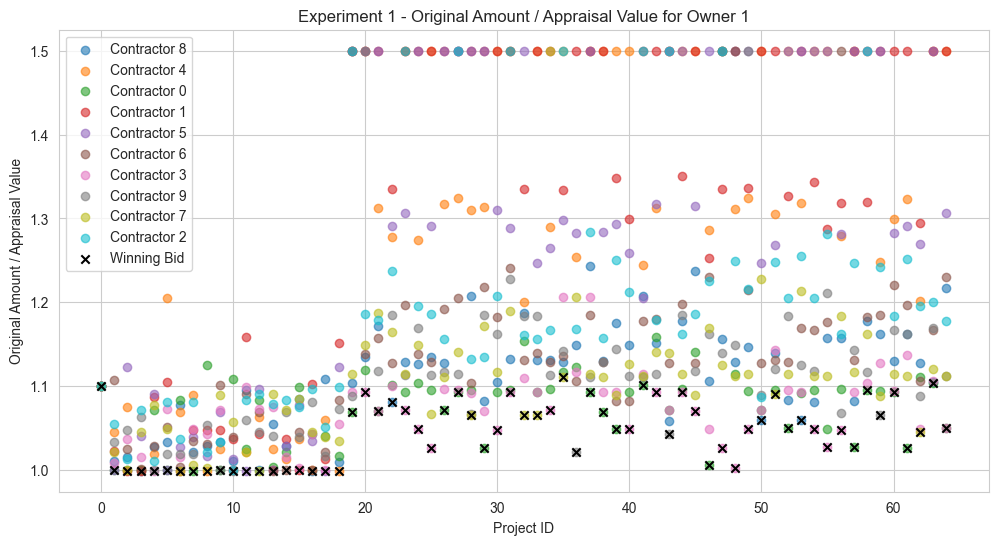

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_single_experiment(model, experiment_number):
    # Build a mapping from project_id to owner_id
    project_owner_map = {project.id: project.owner_id for project in model.all_projects}

    # Create bids dataframe
    bids_data = []
    for agent in model.schedule.agents:
        for bid in agent.contractor.past_bids:
            owner_id = project_owner_map.get(bid.project_id)
            bids_data.append({
                'bid_id': bid.bid_id,
                'original_amount': bid.original_amount,
                'evaluated_amount': bid.evaluated_amount,
                'contractor_id': bid.contractor_id,
                'bid_ratio':bid.bid_ratio,
                'perceived_cost': bid.perceived_cost,
                'project_id': bid.project_id,
                'sustainability_score': bid.sustainability_score,
                'step': bid.step,
                'investment_percentage': bid.investment_percentage,
                'owner_id': owner_id,  # Include owner_id
                'appraisal_value': bid.project.appraisal_value  # Add appraisal value
            })
    bids_df = pd.DataFrame(bids_data)

    # Calculate original amount as a percentage of appraisal value
    bids_df['original_amount_to_appraisal'] = bids_df['original_amount'] / bids_df['appraisal_value']

    # Filter out markups higher than 1.49
    #bids_df = bids_df[bids_df['original_amount_to_appraisal'] <= 1.45]

    # Calculate the average markup
    average_markup = bids_df['original_amount_to_appraisal'].mean()
    print(f"Average Markup: {average_markup}")

    # Winning original amounts
    winning_amount_data = []
    for award in model.project_awards:
        project_id = award.project_id
        winning_bid_id = award.winning_bid_id
        owner_id = project_owner_map.get(project_id)
        # Find the winning bid
        winning_bid_row = bids_df[bids_df['bid_id'] == winning_bid_id]
        if not winning_bid_row.empty:
            winning_amount = winning_bid_row.iloc[0]['original_amount_to_appraisal']
            winning_amount_data.append({
                'project_id': project_id,
                'winning_amount_to_appraisal': winning_amount,
                'owner_id': owner_id,
            })
    winning_amount_df = pd.DataFrame(winning_amount_data)

    # Plot original amount / appraisal value Separated by Owner
    bids_by_owner = bids_df.groupby('owner_id')
    for owner_id, group in bids_by_owner:
        plt.figure(figsize=(12, 6))
        selected_contractors = group['contractor_id'].unique()
        for contractor_id in selected_contractors:
            contractor_bids = group[group['contractor_id'] == contractor_id]
            plt.scatter(contractor_bids['project_id'], contractor_bids['original_amount_to_appraisal'], label=f'Contractor {contractor_id}', alpha=0.6)

        # Extract winning bids for projects belonging to this owner
        owner_winning_bids = winning_amount_df[winning_amount_df['owner_id'] == owner_id]
        plt.scatter(owner_winning_bids['project_id'], owner_winning_bids['winning_amount_to_appraisal'], color='black', label='Winning Bid', marker='x')

        plt.title(f'Experiment {experiment_number} - Original Amount / Appraisal Value for Owner {owner_id}')
        plt.xlabel('Project ID')
        plt.ylabel('Original Amount / Appraisal Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# You can now call this function with your model and experiment number
visualize_single_experiment(model, experiment_number=1)

#NEW MODEL OUTPUT

In [8]:
def plot_sustainability_score_over_projects(bids_df):
    # Filter data for owner_id = 1
    owner_data = bids_df[bids_df['owner_id'] == 1]

    fig, ax = plt.subplots(figsize=(12, 7))

    # Standard norm without flipping values
    norm = colors.Normalize(vmin=owner_data['t_value'].min(), vmax=owner_data['t_value'].max())
    cmap = cm.get_cmap('viridis')

    for contractor_id in owner_data['contractor_id'].unique():
        contractor_data = owner_data[owner_data['contractor_id'] == contractor_id].sort_values('project_index')
        for i in range(len(contractor_data) - 1):
            x_values = contractor_data['project_index'].iloc[i:i+2]
            y_values = contractor_data['sustainability_score'].iloc[i:i+2]
            t_value = contractor_data['t_value'].iloc[i]
            color = cmap(norm(t_value))

            ax.plot(x_values, y_values, color=color)

    ax.set_title('Sustainability Score over Projects (Owner 1)')
    ax.set_xlabel('Project Sequence')
    ax.set_ylabel('Sustainability Score')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('t value')

    # Flip the colorbar ticks
    cbar.ax.invert_yaxis()

    plt.show()

def plot_markup_over_projects(bids_df):
    # Filter data for owner_id = 1
    owner_data = bids_df[bids_df['owner_id'] == 1]

    fig, ax = plt.subplots(figsize=(12, 7))

    # Standard norm without flipping values
    norm = colors.Normalize(vmin=owner_data['t_value'].min(), vmax=owner_data['t_value'].max())
    cmap = cm.get_cmap('viridis')

    for contractor_id in owner_data['contractor_id'].unique():
        contractor_data = owner_data[owner_data['contractor_id'] == contractor_id].sort_values('project_index')
        for i in range(len(contractor_data) - 1):
            x_values = contractor_data['project_index'].iloc[i:i+2]
            y_values = contractor_data['markup'].iloc[i:i+2]
            t_value = contractor_data['t_value'].iloc[i]
            color = cmap(norm(t_value))

            ax.plot(x_values, y_values, color=color)

    ax.set_title('Markup over Projects (Owner 1)')
    ax.set_xlabel('Project Sequence')
    ax.set_ylabel('Markup')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('t value')

    # Flip the colorbar ticks
    cbar.ax.invert_yaxis()

    plt.show()

def plot_evaluated_markup_over_projects(bids_df):
    # Filter data for owner_id = 1
    owner_data = bids_df[bids_df['owner_id'] == 1]

    fig, ax = plt.subplots(figsize=(12, 7))

    # Standard norm without flipping values
    norm = colors.Normalize(vmin=owner_data['t_value'].min(), vmax=owner_data['t_value'].max())
    cmap = cm.get_cmap('viridis')

    for contractor_id in owner_data['contractor_id'].unique():
        contractor_data = owner_data[owner_data['contractor_id'] == contractor_id].sort_values('project_index')
        for i in range(len(contractor_data) - 1):
            x_values = contractor_data['project_index'].iloc[i:i+2]
            y_values = contractor_data['evaluated_markup'].iloc[i:i+2]
            t_value = contractor_data['t_value'].iloc[i]
            color = cmap(norm(t_value))

            ax.plot(x_values, y_values, color=color)

    ax.set_ylim(0.7, 1.5)
    ax.set_title('Evaluated Markup over Projects (Owner 1)')
    ax.set_xlabel('Project Sequence')
    ax.set_ylabel('Evaluated Markup')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('t value')

    # Flip the colorbar ticks
    cbar.ax.invert_yaxis()

    plt.show()

In [10]:
# Process the model to get bids data
bids_df = process_model(model)

# Plot sustainability score over projects
plot_sustainability_score_over_projects(bids_df)

# Plot markup over projects
plot_markup_over_projects(bids_df)

plot_evaluated_markup_over_projects(bids_df)

NameError: name 'process_model' is not defined